# Torchgeo Первый эксперимент

## Введение

Цель этого ноутбука - попробовать применить torchgeo к нашему созданному датасету:
* Создание наборов растровых данных, загрузчиков данных и сэмплеров для изображений и масок;
* Набор данных о пересечениях;
* Нормализация данных;
* Создание спектрального индекса;
* Создание модели сегментации (DeepLabV3);
* Функция потерь и показатели; и
* Цикл обучения.



In [ ]:
# for colab
# !pip install rasterio -q
# !pip install torchgeo -q

In [1]:
# Check cuda and it is available
import torch
print(f'Cuda is available: {torch.cuda.is_available()}')
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

c:\Users\Кирилл\Documents\GitHub\CV_ITMO_2023\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cuda is available: True
PyTorch version: 1.13.1+cu117
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Jun__8_16:59:34_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.7, V11.7.99
Build cuda_11.7.r11.7/compiler.31442593_0
**********
CUDNN version: 8500
Available GPU devices: 1
Device Name: NVIDIA GeForce GTX 1650 with Max-Q Design


## Dataset

Датасет мы создали ранее, его можно найти в папке `data/output/for_torchgeo_way/`




## Imports

In [2]:
from pathlib import Path
from typing import Optional, Iterable, List, Callable
import matplotlib.pyplot as plt

import rasterio as rio

from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torch.utils.data import DataLoader

import torch

In [3]:
import logging
# this line is to avoid warnings from Rasterio to be printed on screen
# the warning is explained here: https://stackoverflow.com/questions/74089170/suppress-rasterio-warning-warning-1-tiffreaddirectory
logger = logging.getLogger("rasterio")
logger.setLevel(logging.ERROR)

In [4]:
root = Path('./data/output/for_torchgeo_way')
assert root.exists()

## Создание датасета

Нужно подготовить его к загрузке в нейронную сеть. Для этого мы создадим экземпляр класса Raster Dataset, предоставляемого TorchGeo, и укажем на каталог датасета. Функция `scale` применит масштабирование - `1e-4`, (увидел у одного ученого проверим, нужно ли это делать). Как только наборы данных созданы, мы можем комбинировать изображения с масками (метками), используя оператор `&`.

In [5]:
def scale(item: dict):
    item['image'] = (item['image']-torch.min(item['image']))/(torch.max(item['image'])-torch.min(item['image']))
    return item

In [6]:
#res - resolution, like the scale of the image, 10 means 10 m in pixel, as it is in Sentinel-2
train_imgs = RasterDataset(root=(root/'img_f/train').as_posix(), crs='epsg:32637', res=10, transforms=scale) 
train_msks = RasterDataset(root=(root/'mask_f/train').as_posix(), crs='epsg:32637', res=10)

valid_imgs = RasterDataset(root=(root/'img_f/val').as_posix(), crs='epsg:32637', res=10, transforms=scale)
valid_msks = RasterDataset(root=(root/'mask_f/val').as_posix(), crs='epsg:32637', res=10)

# IMPORTANT
train_msks.is_image = False
valid_msks.is_image = False

train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks

train_sampler = RandomGeoSampler(train_imgs, size=256, length=600, units=Units.PIXELS)
valid_sampler = RandomGeoSampler(valid_imgs, size=256, length=300, units=Units.PIXELS)


CRS (Coordinate Reference System) - TorchGeo требует, чтобы все изображения были с одинаковой системой координат.

### Понимание sampler -а

Чтобы создать патчи для обучения, которые могут быть загружены в нейронную сеть из нашего набора данных, нам нужно взять выборки (sampler) фиксированного размера. Torch Geo имеет много сэмплеров, но мы попробуем класс `RandomGeoSampler`. По сути, сэмплер выбирает случайные ограничивающие рамки фиксированного размера, которые принадлежат исходному изображению. Затем эти ограничивающие рамки используются в `RasterDataset` для запроса нужной нам части изображения. Пример с использованием ранее созданных сэмплеров ниже.

In [7]:
bbox = next(iter(train_sampler))
bbox

BoundingBox(minx=374164.47866022587, maxx=376724.47866022587, miny=6345587.2473835945, maxy=6348147.2473835945, mint=0.0, maxt=9.223372036854776e+18)

In [8]:
sample = train_dset[bbox]
sample.keys()

dict_keys(['crs', 'bbox', 'image', 'mask'])

In [9]:
sample['image'].shape, sample['mask'].shape

(torch.Size([4, 256, 256]), torch.Size([1, 256, 256]))

Обратите внимание, что теперь у нас есть участки одинакового размера (..., 256 x 256)

## Создание Dataloaders

Создание `DataLoader` в TorchGeo очень простое, такое же, как и в Pytorch (фактически используется тот же класс). Обратите внимание ниже, что мы используем те же sampler, которые ранее задали. Дополнительно мы сообщаем dataset, который загрузчик данных будет использовать для извлечения данных, batch_size (количество выборок в каждом пакете) и функцию сортировки, которая определяет, как “объединить” несколько выборок в один пакет.

Наконец, мы можем выполнить итерацию через загрузчик данных, чтобы извлекать из него пакеты. Чтобы протестировать это, давайте получим первую партию.

In [10]:
train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size=4, collate_fn=stack_samples)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size=4, collate_fn=stack_samples)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()

(dict_keys(['crs', 'bbox', 'image', 'mask']),
 dict_keys(['crs', 'bbox', 'image', 'mask']))

## Batch визуализация

Теперь, когда мы можем извлекать пакеты из наших наборов данных, давайте создадим функцию для отображения пакетов.

Функция `plot_batch` автоматически проверит количество элементов в пакете и наличие связанных масок, чтобы соответствующим образом упорядочить выходную сетку.

In [11]:
def plot_imgs(images: Iterable, axs: Iterable):
    for img, ax in zip(images, axs):
        arr = img[:3, :, :].permute(1, 2, 0).numpy()
        ax.imshow(arr)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='Greens')
        ax.axis('off')

def plot_batch(batch: dict, cols: int = 4, width: int = 5):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())
    
    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))  

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2]) 

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) 

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)) 
    
        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) 

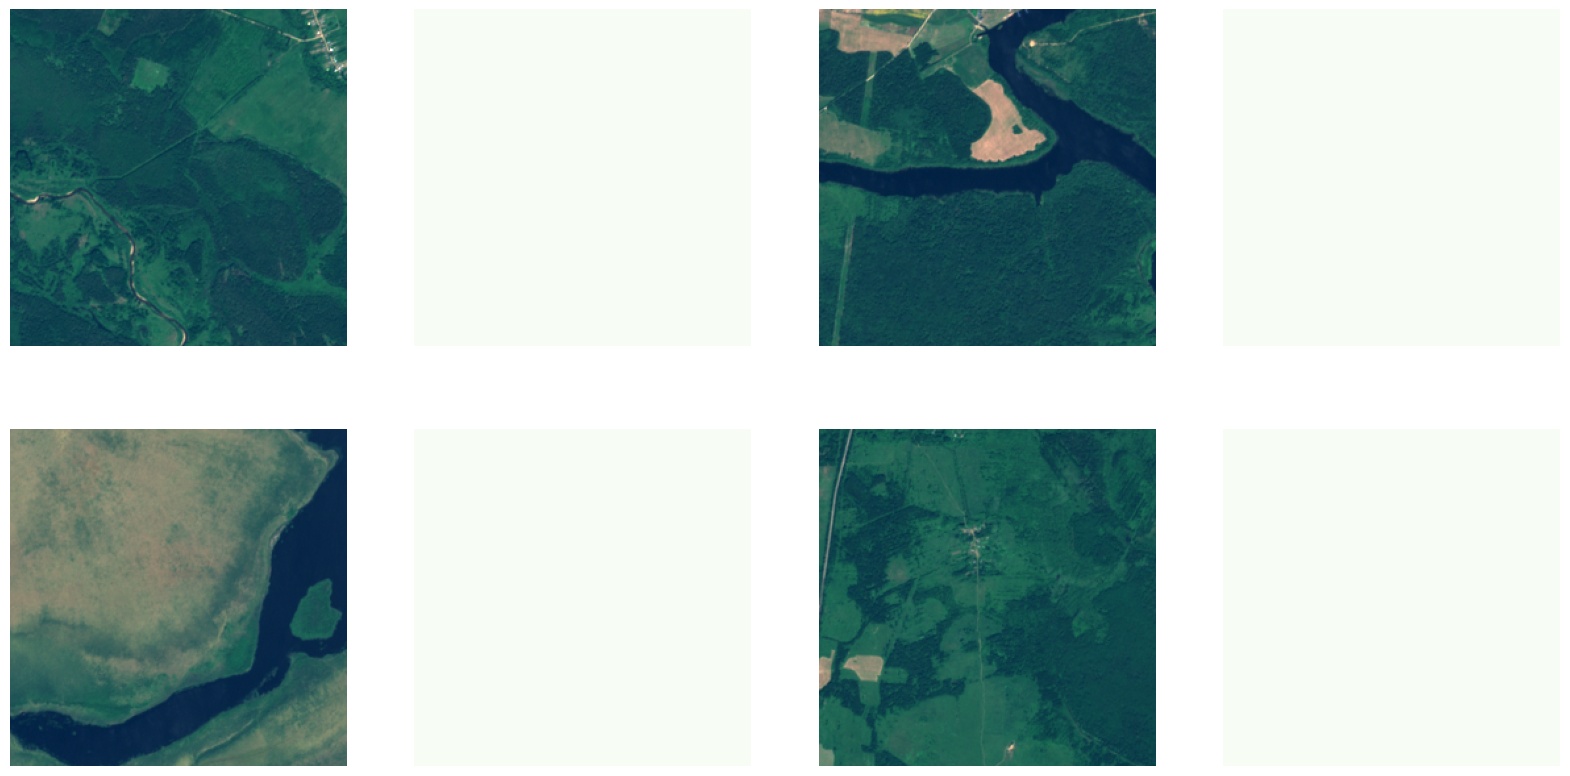

In [12]:
plot_batch(train_batch)

## Стандартизация данных и спектральный индекс

Обычно методы машинного обучения (включая глубокое обучение) выигрывают от масштабирования функций. Это означает стандартное отклонение около 1 и нулевое среднее значение, применяя следующую формулу:
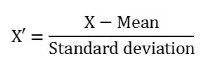

Чтобы сделать это, нам нужно сначала найти среднее значение и стандартное отклонение для каждого из 4х каналов в наборе данных.

Давайте определим функцию, вычисляющую эти статистические данные, и запишем ее результаты в переменные mean и std. Мы будем использовать наш ранее установленный пакет rasterio, чтобы открыть изображения и выполнить простое усреднение статистики для каждого пакета / канала. Для стандартного отклонения этот метод является приближенным. Для более точного расчета, пожалуйста, обратитесь к: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.htm.

In [13]:
def calc_statistics(dset: RasterDataset):
        """
        Calculate the statistics (mean and std) for the entire dataset
        Warning: This is an approximation. The correct value should take into account the
        mean for the whole dataset for computing individual stds.
        For correctness I suggest checking: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        """

        # To avoid loading the entire dataset in memory, we will loop through each img
        # The filenames will be retrieved from the dataset's rtree index
        files = [item.object for item in dset.index.intersection(dset.index.bounds, objects=True)]

        # Reseting statistics
        accum_mean = 0
        accum_std = 0

        for file in files:
            img = rio.open(file).read() #type: ignore
            accum_mean += img.reshape((img.shape[0], -1)).mean(axis=1)
            accum_std += img.reshape((img.shape[0], -1)).std(axis=1)

        # at the end, we shall have 2 vectors with lenght n=chnls
        # we will average them considering the number of images
        return accum_mean / len(files), accum_std / len(files)

In [14]:
class MyNormalize(torch.nn.Module):
    def __init__(self, mean: List[float], stdev: List[float]):
        super().__init__()

        self.mean = torch.Tensor(mean)[:, None, None]
        self.std = torch.Tensor(stdev)[:, None, None]

    def forward(self, inputs: dict):

        x = inputs[..., : len(self.mean), :, :]

        # if batch
        if inputs.ndim == 4:
            x = (x - self.mean[None, ...]) / self.std[None, ...]

        else:
            x = (x - self.mean) / self.std

        inputs[..., : len(self.mean), :, :] = x

        return inputs

    def revert(self, inputs: dict):
        """
        De-normalize the batch.

        Args:
            inputs (dict): Dictionary with the 'image' key
        """

        x = inputs[..., : len(self.mean), :, :]

        # if batch
        if x.ndim == 4:
            x = inputs[:, : len(self.mean), ...]
            x = x * self.std[None, ...] + self.mean[None, ...]
        else:
            x = x * self.std + self.mean

        inputs[..., : len(self.mean), :, :] = x

        return inputs


In [15]:
normalize = MyNormalize(*calc_statistics(train_imgs))

tfms = torch.nn.Sequential(
    indices.AppendNDVI(index_nir=3, index_red=0),
    normalize
)

In [16]:
transformed_batch = tfms(train_batch['image'])
print(transformed_batch.shape)

torch.Size([4, 5, 256, 256])


Обратите внимание, что наш преобразованный пакет теперь содержит 5 каналов вместо 4.

> Важно: созданный нами метод normalize применит нормализацию только к исходным полосам и проигнорирует ранее добавленные индексы. Это важно, чтобы избежать ошибок из-за различий в формах между пакетом и векторами mean и std.

## Модель для сегментации

В качестве семантической сегментации используем предопределенную архитектуру, доступную в Pytorch. Согласно списка (https://pytorch.org/vision/stable/models.html#semantic-segmentation ) можно отметить 3 модели, доступные для сегментации, но одна (LRASPP) предназначена для мобильных приложений. В нашем руководстве мы будем использовать модель DeepLabV3.

Здесь мы создадим модель DeepLabV3 для 2 классов. В этом случае я пропущу предварительно подготовленные веса, поскольку веса представляют другую область (не сегментацию воды по мультиспектральным изображениям).

In [17]:
from torchvision.models.segmentation import deeplabv3_resnet50
model = deeplabv3_resnet50(weights=None, num_classes=2)

model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Первое, на что мы должны обратить внимание в архитектуре модели, - это количество каналов, ожидаемое в первой свертке (Conv2d), которое определяется как 3. Это потому, что модель подготовлена для работы с изображениями RGB. После первой свертки 3 канала будут выдавать 64 канала с более низким разрешением и так далее. Поскольку теперь у нас 5 каналов, мы изменим этот первый уровень обработки, чтобы он правильно адаптировался к нашей модели. Мы можем сделать это, заменив первый сверточный слой на новый. И проверим, что пробная партия может пройти через модель, и предоставляем на выходе 2 канала (heracleum / no_heracleum).

In [18]:
backbone = model.get_submodule('backbone')

conv = torch.nn.modules.conv.Conv2d(
    in_channels=5, 
    out_channels=64, 
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
)
backbone.register_module('conv1', conv)

pred = model(torch.randn(4, 5, 256, 256))
pred['out'].shape

torch.Size([4, 2, 256, 256])

## Цикл обучения

Обучающая функция принимает на вход: количество эпох, модель, загрузчики данных, функцию потерь (подлежащую оптимизации), функцию точности (для оценки результатов), оптимизатор (который будет корректировать параметры модели в правильном направлении) и преобразования, которые будут применены к каждой партии.

In [19]:
def train_loop(
    epochs: int, 
    train_dl: DataLoader, 
    val_dl: Optional[DataLoader], 
    model: torch.nn.Module, 
    loss_fn: Callable, 
    optimizer: torch.optim.Optimizer, 
    acc_fns: Optional[List]=None, 
    batch_tfms: Optional[Callable]=None
):
    # size = len(dataloader.dataset)
    cuda_model = model.cuda()

    for epoch in range(epochs):
        accum_loss = 0
        for batch in train_dl:

            if batch_tfms is not None:
                batch['image'] = batch_tfms(batch['image'])

            X = batch['image'].cuda()
            y = batch['mask'].type(torch.long).cuda()
            pred = cuda_model(X)['out']
            loss = loss_fn(pred, y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update the accum loss
            accum_loss += float(loss) / len(train_dl)

        # Testing against the validation dataset
        if acc_fns is not None and val_dl is not None:
            # reset the accuracies metrics
            acc = [0.] * len(acc_fns)

            with torch.no_grad():
                for batch in val_dl:

                    if batch_tfms is not None:
                        batch['image'] = batch_tfms(batch['image'])                    

                    X = batch['image'].type(torch.float32).cuda()
                    y = batch['mask'].type(torch.long).cuda()

                    pred = cuda_model(X)['out']

                    for i, acc_fn in enumerate(acc_fns):
                        acc[i] = float(acc[i] + acc_fn(pred, y)/len(val_dl))

            # at the end of the epoch, print the errors, etc.
            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f} - Accs={[round(a, 3) for a in acc]}')
        else:

            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f}')

## Функция потерь и точности

Перед вызовом обучающей функции создадим функции потерь и точности. В нашем случае у нас будут предсказания с формой (N, C, d1, d2), и у нас будут маски с формой (N, 1, d1, d2). В качестве функции должна хорошо работать Cross Entropy Loss, но для этого требуется, чтобы маска имела форму (N, d1, d2). В этом случае нам нужно будет сжать наше второе измерение вручную.

Кроме того, мы создадим две функции точности. Общая точность (overall accuracy), и пересечение над объединением (intersect over union). Так как, когда у нас есть маски с несбалансированным количеством пикселей в каждом классе, как в нашем случае (есть области без борщевика), общая точность приведет к нереалистичным значениям.

Общая точность рассчитывается вручную путем суммирования всех совпадений и деления на количество элементов в пакете. IoU также известна как индекс Jaccard и доступна в пакете Sklearn. Перекрестная энтропия Pytorch используется для компенсации потерь с незначительной корректировкой формы цели.

In [20]:
from sklearn.metrics import jaccard_score

def oa(pred, y):
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc

def iou(pred, y):
    flat_y = y.cpu().numpy().squeeze()
    flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
    return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1.)    

def loss(p, t):    
    return torch.nn.functional.cross_entropy(p, t.squeeze())

## Обучение

In [21]:
# for clean cache
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [22]:
# for debuging
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
train_loop(20, train_dataloader, valid_dataloader, model, loss, optimizer, 
           acc_fns=[iou], batch_tfms=tfms) # acc_fns=[oa, iou]

Из результатов мы можем видеть, что потери снижаются, а точность увеличивается. Таким образом, наше обучение работает так, как ожидалось. Первая точность - это overall accuracy, а вторая - IoU

In [ ]:
torch.save(model.state_dict(), './model1.pt')

In [23]:
model = deeplabv3_resnet50(weights=None, num_classes=2)
backbone = model.get_submodule('backbone')

conv = torch.nn.modules.conv.Conv2d(
    in_channels=5, 
    out_channels=64, 
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
)
backbone.register_module('conv1', conv)
model.load_state_dict(torch.load('./model1.pt'))
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## Сравнение результатов

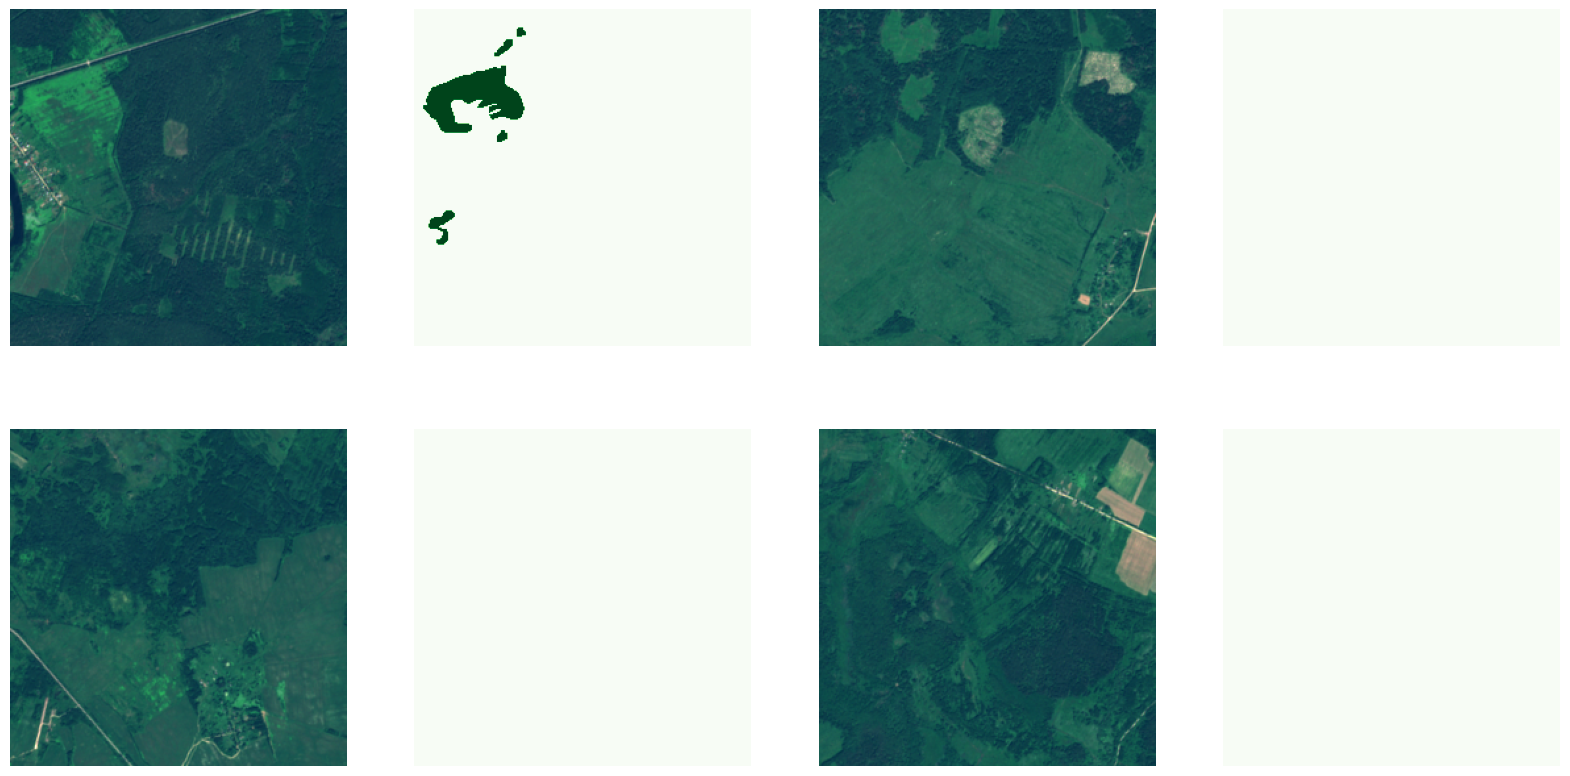

In [24]:
valid_batch = next(iter(valid_dataloader))
try_batch = tfms(valid_batch['image'])
plot_batch(valid_batch)

In [25]:
X = try_batch.type(torch.float32)

pred = model(X)['out']

In [30]:
from torchvision.transforms.functional import to_pil_image
normalized_masks = pred.softmax(dim=1)
class_to_idx = {'no_heracleum': 0,
                'heracleum': 1}
mask = normalized_masks[3, class_to_idx["heracleum"]]
to_pil_image(mask).show()

Пока модель ищет хреново, надо попробовать сменить лосс функцию на Dice или Fecal. Или сменить архитектуру и попробовать все через истинный torchgeo, привязать все к clearml и дальше проводить эксперименты. И засунуть ноутбук в py файлы, в самом конце(? в конце ли)